## Importing Libraries

In [30]:
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import KNNImputer
from datetime import datetime
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Layer, Input, GRU, SimpleRNN
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
import shap

In [31]:
# Hide warnings!
import warnings
warnings.filterwarnings("ignore")

In [32]:
# For reproducibility
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## Forecasting SO2 based on PM2.5 pre-trained model

In [33]:
# Importing dataset from station Aotizhongxin
df = pd.read_csv("datasets/cleaned_df.csv")

In [34]:
df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,6,4.4
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,3,4.7
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,6,5.6
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,7,3.1
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35059,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,7,2.4
35060,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,14,0.9
35061,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,7,1.1
35062,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,6,1.2


In [35]:
# Defining features and target
features_SO2 = df.drop(columns = ['PM10','NO2','PM2.5','CO','O3'])

In [36]:
features_SO2

,SO2,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,4.0,-0.7,1023.0,-18.8,0.0,6,4.4
1,4.0,-1.1,1023.2,-18.2,0.0,3,4.7
2,5.0,-1.1,1023.5,-18.2,0.0,6,5.6
3,11.0,-1.4,1024.5,-19.4,0.0,7,3.1
4,12.0,-2.0,1025.2,-19.5,0.0,3,2.0
...,...,...,...,...,...,...,...
35059,5.0,12.5,1013.5,-16.2,0.0,7,2.4
35060,7.0,11.6,1013.6,-15.1,0.0,14,0.9
35061,10.0,10.8,1014.2,-13.3,0.0,7,1.1
35062,12.0,10.5,1014.4,-12.9,0.0,6,1.2


In [37]:
features_SO2.isna().sum()

SO2     0
TEMP    0
PRES    0
DEWP    0
RAIN    0
wd      0
WSPM    0
dtype: int64

In [38]:
# Changing the position of the 'wd' column

# Column to move
col_to_move = 'wd'

# Get a list of all columns
cols = list(features_SO2.columns)

# Remove the column from the list
cols.remove(col_to_move)

# Append the column to the end of the list
cols.append(col_to_move)

# Reindex the DataFrame
features_SO2 = features_SO2[cols]

In [39]:
features_SO2

,SO2,TEMP,PRES,DEWP,RAIN,WSPM,wd
0,4.0,-0.7,1023.0,-18.8,0.0,4.4,6
1,4.0,-1.1,1023.2,-18.2,0.0,4.7,3
2,5.0,-1.1,1023.5,-18.2,0.0,5.6,6
3,11.0,-1.4,1024.5,-19.4,0.0,3.1,7
4,12.0,-2.0,1025.2,-19.5,0.0,2.0,3
...,...,...,...,...,...,...,...
35059,5.0,12.5,1013.5,-16.2,0.0,2.4,7
35060,7.0,11.6,1013.6,-15.1,0.0,0.9,14
35061,10.0,10.8,1014.2,-13.3,0.0,1.1,7
35062,12.0,10.5,1014.4,-12.9,0.0,1.2,6


In [40]:
# Create sequences
SEQ_LENGTH = 1
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [41]:
fine_tuning_size = [0.1, 0.2, 0.3, 0.4, 0.5]

In [42]:
best_params_ann = {'num_hidden_layers': 1, 'num_units': 8, 'dropout_rate': 0.14382634727054072, 
                  'learning_rate': 0.001540087615233534, 'regularization': None, 
                  'regularization_strength': 0}

In [43]:
def train_test_split_standardize(train_size):
    
    len_train = int(train_size * len(features_SO2))
    
    train_df = features_SO2.iloc[:len_train, :-1]
    test_df = features_SO2.iloc[len_train:, :-1]
    
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    train_df['wd'] = features_SO2.iloc[:len_train, -1]
    test_df['wd'] = features_SO2.iloc[len_train:, -1]
    
    X_train, y_train = create_sequences(np.array(train_df), SEQ_LENGTH)
    X_test, y_test = create_sequences(np.array(test_df), SEQ_LENGTH)
    
    return X_train, y_train, X_test, y_test

In [44]:
X_train_SO2, y_train_SO2, X_test_SO2, y_test_SO2 = train_test_split_standardize(0.3)

In [45]:
print("Train shape: ", X_train_SO2.shape)
print("Test shape: ", X_test_SO2.shape)

Train shape:  (10518, 1, 7)
Test shape:  (24544, 1, 7)


In [46]:
X_train_SO2

array([[[-8.06671330e-01, -1.30927509e+00,  1.30236737e+00, ...,
         -6.20225909e-02,  2.44235361e+00,  6.00000000e+00]],

       [[-8.06671330e-01, -1.34717207e+00,  1.32307167e+00, ...,
         -6.20225909e-02,  2.70391712e+00,  3.00000000e+00]],

       [[-7.73830910e-01, -1.34717207e+00,  1.35412812e+00, ...,
         -6.20225909e-02,  3.48860768e+00,  6.00000000e+00]],

       ...,

       [[-4.78267133e-01, -1.13035246e-02, -1.61693932e+00, ...,
         -6.20225909e-02, -8.70784300e-01,  1.00000000e+00]],

       [[-5.11107552e-01,  1.71192105e-02, -1.59623501e+00, ...,
         -6.20225909e-02, -7.83596461e-01,  1.00000000e+00]],

       [[-5.76788392e-01,  1.21335906e-01, -1.52376996e+00, ...,
         -6.20225909e-02,  1.09409591e-03,  4.00000000e+00]]])

In [74]:
mse_scores = []
mae_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []

for s in fine_tuning_size:
    
    # Training set
    
    X_train_SO2, y_train_SO2, X_test_SO2, y_test_SO2 = train_test_split_standardize(s)
        
    # Loading the saved model
    pre_trained_model = tf.keras.models.load_model('pre_trained_models/LSTM_model.h5')
    pre_trained_model.compile(optimizer=Adam(learning_rate = best_params_ann['learning_rate']/10), loss='mse', metrics=['mae'])
    pre_trained_model.fit(X_train_SO2, y_train_SO2, epochs = 50, batch_size=32, shuffle=False)
    
    # Make predictions on the test data
    y_pred_ft = pre_trained_model.predict(X_test_SO2)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test_SO2, y_pred_ft)
    mae = mean_absolute_error(y_test_SO2, y_pred_ft)
    r2 = r2_score(y_test_SO2, y_pred_ft)
    mape = mean_absolute_percentage_error(y_test_SO2, y_pred_ft)
    rmse = np.sqrt(mean_squared_error(y_test_SO2, y_pred_ft))
    
    # Append to list scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    

Epoch 1/50
110/110 [==============================] - 3s 4ms/step - loss: 0.1391 - mae: 0.2102
Epoch 2/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1435 - mae: 0.2097
Epoch 3/50
110/110 [==============================] - 0s 4ms/step - loss: 0.1409 - mae: 0.2130
Epoch 4/50
110/110 [==============================] - 0s 4ms/step - loss: 0.1332 - mae: 0.2034
Epoch 5/50
110/110 [==============================] - 0s 4ms/step - loss: 0.1352 - mae: 0.2047
Epoch 6/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1302 - mae: 0.2027
Epoch 7/50
110/110 [==============================] - 0s 4ms/step - loss: 0.1361 - mae: 0.2070
Epoch 8/50
110/110 [==============================] - 0s 4ms/step - loss: 0.1340 - mae: 0.2071
Epoch 9/50
110/110 [==============================] - 0s 4ms/step - loss: 0.1339 - mae: 0.2054
Epoch 10/50
110/110 [==============================] - 0s 4ms/step - loss: 0.1388 - mae: 0.2049
Epoch 11/50
110/110 [============================

Epoch 36/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1322 - mae: 0.1999
Epoch 37/50
220/220 [==============================] - 1s 4ms/step - loss: 0.1346 - mae: 0.2011
Epoch 38/50
220/220 [==============================] - 1s 4ms/step - loss: 0.1294 - mae: 0.1998
Epoch 39/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1317 - mae: 0.1989
Epoch 40/50
220/220 [==============================] - 1s 4ms/step - loss: 0.1341 - mae: 0.2014
Epoch 41/50
220/220 [==============================] - 1s 4ms/step - loss: 0.1332 - mae: 0.1986
Epoch 42/50
220/220 [==============================] - 1s 4ms/step - loss: 0.1321 - mae: 0.1983
Epoch 43/50
220/220 [==============================] - 1s 4ms/step - loss: 0.1285 - mae: 0.1975
Epoch 44/50
220/220 [==============================] - 1s 4ms/step - loss: 0.1330 - mae: 0.1995
Epoch 45/50
220/220 [==============================] - 1s 4ms/step - loss: 0.1270 - mae: 0.1959
Epoch 46/50
220/220 [===================

439/439 [==============================] - 2s 4ms/step - loss: 0.1088 - mae: 0.1772
Epoch 21/50
439/439 [==============================] - 2s 4ms/step - loss: 0.1085 - mae: 0.1758
Epoch 22/50
439/439 [==============================] - 2s 4ms/step - loss: 0.1100 - mae: 0.1768
Epoch 23/50
439/439 [==============================] - 2s 4ms/step - loss: 0.1039 - mae: 0.1755
Epoch 24/50
439/439 [==============================] - 2s 4ms/step - loss: 0.1070 - mae: 0.1758
Epoch 25/50
439/439 [==============================] - 2s 3ms/step - loss: 0.1068 - mae: 0.1759
Epoch 26/50
439/439 [==============================] - 2s 4ms/step - loss: 0.1064 - mae: 0.1763
Epoch 27/50
439/439 [==============================] - 2s 4ms/step - loss: 0.1078 - mae: 0.1753
Epoch 28/50
439/439 [==============================] - 2s 3ms/step - loss: 0.1082 - mae: 0.1756
Epoch 29/50
439/439 [==============================] - 2s 3ms/step - loss: 0.1059 - mae: 0.1730
Epoch 30/50
439/439 [==============================]

In [79]:
mae_scores

[0.1317954051238263,
 0.13905018506555977,
 0.10876757661284682,
 0.10417286923048795,
 0.1021163481280105]

In [80]:
mse_scores

[0.05175320683376343,
 0.061244804125347115,
 0.028052403254397028,
 0.03269198801790433,
 0.02813998122059357]

In [81]:
r2_scores

[0.9238100156187845,
 0.9264594540344935,
 0.9045799791529429,
 0.9122022367866626,
 0.9046395579267618]

In [82]:
rmse_scores

[0.2274933116242397,
 0.24747687594065657,
 0.1674885167836799,
 0.18080925866200637,
 0.16774975773631856]

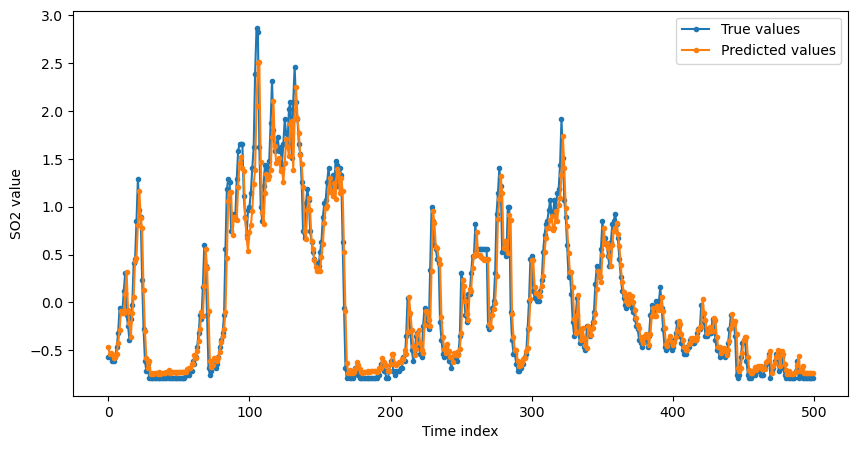

In [23]:
# Forecasting test set values

fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(np.array(y_test_SO2)[:500], marker = '.', label = 'True values')
plt.plot(y_pred_ft[:500], marker = '.', label = 'Predicted values')

plt.legend()

plt.xlabel("Time index")
plt.ylabel("SO2 value")

#plt.savefig("actual_vs_forecasts_plot_SO2.pdf")
plt.show()

## Forecasting SO2 without Transfer Learning

In [24]:
def build_ann_model(input_shape):
    
    model = Sequential()
    
    model.add(Flatten(input_shape=input_shape))
    
    model.add(Dense(8, activation='relu'))
              
    model.add(Dropout(best_params_ann['dropout_rate']))
        
    model.add(Dense(1, activation='linear'))
                  
    model.compile(optimizer=Adam(learning_rate=best_params_ann['learning_rate']), loss='mse', metrics=['mae'])
    
    return model

In [25]:
mse_scores_2 = []
mae_scores_2 = []
rmse_scores_2 = []
mape_scores_2 = []
r2_scores_2 = []

for s in fine_tuning_size:
    # Training set
    X_train_SO2, y_train_SO2, X_test_SO2, y_test_SO2 = train_test_split_standardize(s)
    
    # Loading the saved model
    model = build_ann_model(X_train_SO2.shape[1:])
    model.fit(X_train_SO2, y_train_SO2, epochs = 50, shuffle = False, batch_size = 32)
    
    # Make predictions on the test data
    y_pred_ft = model.predict(X_test_SO2)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test_SO2, y_pred_ft)
    mae = mean_absolute_error(y_test_SO2, y_pred_ft)
    r2 = r2_score(y_test_SO2, y_pred_ft)
    mape = mean_absolute_percentage_error(y_test_SO2, y_pred_ft)
    rmse = np.sqrt(mean_squared_error(y_test_SO2, y_pred_ft))
    
    # Append to list scores
    mse_scores_2.append(mse)
    mae_scores_2.append(mae)
    r2_scores_2.append(r2)
    rmse_scores_2.append(rmse)
    mape_scores_2.append(mape)
    
    

Epoch 1/50
110/110 [==============================] - 1s 2ms/step - loss: 8.4383 - mae: 2.0706
Epoch 2/50
110/110 [==============================] - 0s 2ms/step - loss: 2.9120 - mae: 1.1695
Epoch 3/50
110/110 [==============================] - 0s 2ms/step - loss: 2.1534 - mae: 1.0417
Epoch 4/50
110/110 [==============================] - 0s 2ms/step - loss: 1.7418 - mae: 0.9591
Epoch 5/50
110/110 [==============================] - 0s 2ms/step - loss: 1.5052 - mae: 0.9025
Epoch 6/50
110/110 [==============================] - 0s 2ms/step - loss: 1.2558 - mae: 0.8332
Epoch 7/50
110/110 [==============================] - 0s 2ms/step - loss: 1.1355 - mae: 0.7962
Epoch 8/50
110/110 [==============================] - 0s 2ms/step - loss: 1.0385 - mae: 0.7582
Epoch 9/50
110/110 [==============================] - 0s 2ms/step - loss: 0.8802 - mae: 0.7092
Epoch 10/50
110/110 [==============================] - 0s 1ms/step - loss: 0.7400 - mae: 0.6604
Epoch 11/50
110/110 [============================

Epoch 36/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1443 - mae: 0.2187
Epoch 37/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1480 - mae: 0.2198
Epoch 38/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1450 - mae: 0.2191
Epoch 39/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1440 - mae: 0.2155
Epoch 40/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1507 - mae: 0.2187
Epoch 41/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1390 - mae: 0.2130
Epoch 42/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1427 - mae: 0.2163
Epoch 43/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1440 - mae: 0.2161
Epoch 44/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1354 - mae: 0.2157
Epoch 45/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1347 - mae: 0.2127
Epoch 46/50
220/220 [===================

439/439 [==============================] - 1s 3ms/step - loss: 0.1265 - mae: 0.1982
Epoch 21/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1207 - mae: 0.1958
Epoch 22/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1237 - mae: 0.1975
Epoch 23/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1157 - mae: 0.1949
Epoch 24/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1185 - mae: 0.1961
Epoch 25/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1209 - mae: 0.1953
Epoch 26/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1167 - mae: 0.1936
Epoch 27/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1149 - mae: 0.1924
Epoch 28/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1149 - mae: 0.1905
Epoch 29/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1135 - mae: 0.1887
Epoch 30/50
439/439 [==============================]

In [26]:
mae_scores_2

[0.22870427014588185,
 0.19346345285819672,
 0.11960662166558332,
 0.10801872883527869,
 0.10876761978780812]

In [27]:
mse_scores_2

[0.09666444453416062,
 0.07744399982620079,
 0.03152879717788402,
 0.03598207044653917,
 0.029836385034671172]

In [28]:
rmse_scores_2

[0.31090906151825265,
 0.27828762068442925,
 0.17756350181803696,
 0.18968940520371497,
 0.17273211929074214]

In [29]:
r2_scores_2

[0.8576926345273008,
 0.9070080456569813,
 0.8927550535790629,
 0.9033663752947446,
 0.8988908043516606]